<a href="https://colab.research.google.com/github/Jholman22/ProcesamientoImagenes2025/blob/main/2_DL_Keras_API_funcional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creación de arquitecturas de aprendizaje profundo mediante API funcional de Keras.

- Se presentan los consideraciones básicas respecto a la [API funcional de Keras](https://keras.io/guides/functional_api/) para la implementación de modelos de redes profundas con TensorFlow.



In [1]:
import tensorflow as tf #importar tensorflow
print(tf.__version__)

2.18.0


- Se utilizará la base de datos Fashion Mnist nuevamente, normalizando las imágenes de 0 a 1.

In [2]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


- Se presenta un ejemplo de la base de datos

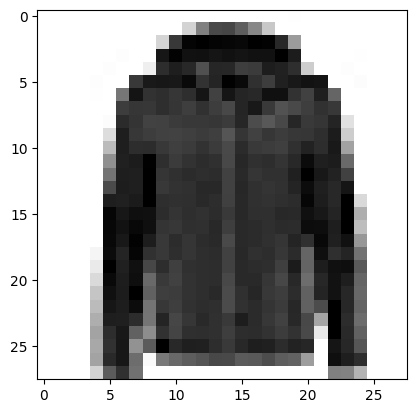

In [3]:
import matplotlib.pyplot as plt
plt.imshow(images[5000,:,:],cmap= 'binary')
plt.show()

In [4]:
import numpy as np
print(np.unique(labels)) #etiquetas
print(images.shape) #tamaño de las imágenes

[0 1 2 3 4 5 6 7 8 9]
(60000, 28, 28)


In [5]:
Xtrain, ytrain = train
Xtrain = Xtrain/255 # tipo flotante, normalizados de 0 a 1
Xtest, ytest = test
Xtest = Xtest/255 # tipo flotante, normalizados de 0 a 1

- En el cuaderno introductorio a redes neuronales con tensorflow se planteó la construcción de modelos mediante secuencia de capas:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ red1 (Dense)                    │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hred2 (Dense)                   │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,560 (654.53 KB)

 Trainable params: 167,560 (654.53 KB)

 Non-trainable params: 0 (0.00 B)

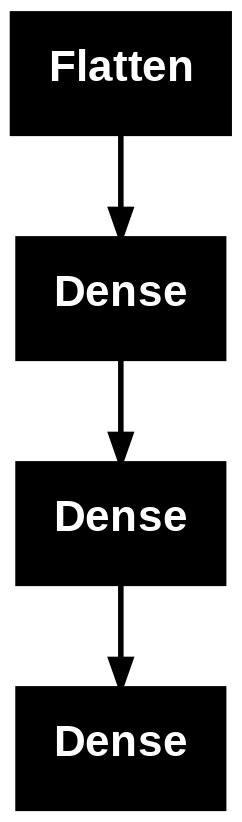

In [6]:
#definir arquitectura secuencial
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2])),
    tf.keras.layers.Dense(200,activation="relu", name='red1'),
    tf.keras.layers.Dense(50, activation="tanh",name='hred2'),
    tf.keras.layers.Dense(10,activation='softmax',name='output')
])

model.summary() # resumen del modelo
tf.keras.utils.plot_model(model) #diagrama del modelo

- Aunque la implementacióm mediante secuencia es intuitiva, no permite realizar conexiones flexibles entre capas.

- En ese sentido, Keras permite crear capas bajo el principio de funciones y argumentos, como se muestra a continuación.

**Nota**: a diferencia de la estructura secuencial, en la API funcional se debe indicar la capa o capas de entrada y la capa o capas de salida para crear el grafo computacional de forma apropiada.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ entrada (InputLayer)            │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h1 (Dense)                      │ (None, 200)            │       157,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 50)             │        10,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,560 (654.53 KB)

 Trainable params: 167,560 (654.53 KB)

 Non-trainable params: 0 (0.00 B)

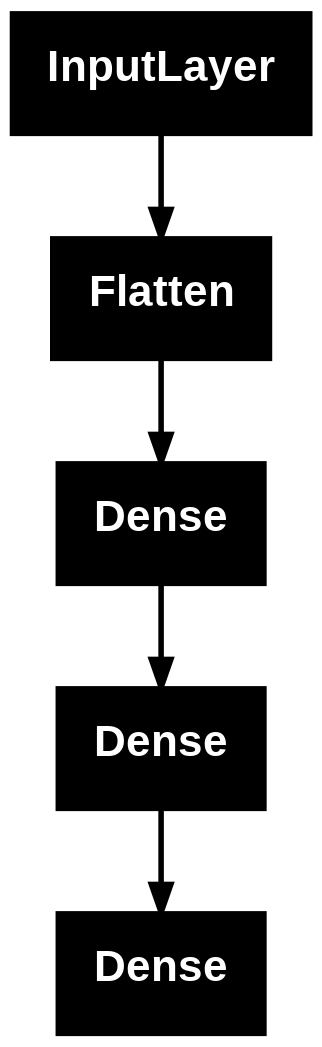

In [7]:
#arquitectura funcional
#capa de entrada
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
#capa de aplanamiento de las imágenes
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)#argumento de entrada
#capas densas
h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)#argumento de entrada
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa de salida
output = tf.keras.layers.Dense(10,activation="softmax",name='output')(h2)
#crear modelo según conexiones tipo funcionales
model_fun = tf.keras.Model(inputs=input_l,outputs=output)

#resumen y gráfica del modelo
model_fun.summary()
tf.keras.utils.plot_model(model_fun)


# La API funcional permite realizar conexiones más flexibles

- En el siguiente ejemplo se crea un modelo con una entrada y dos salidas con interconexiones flexibles:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


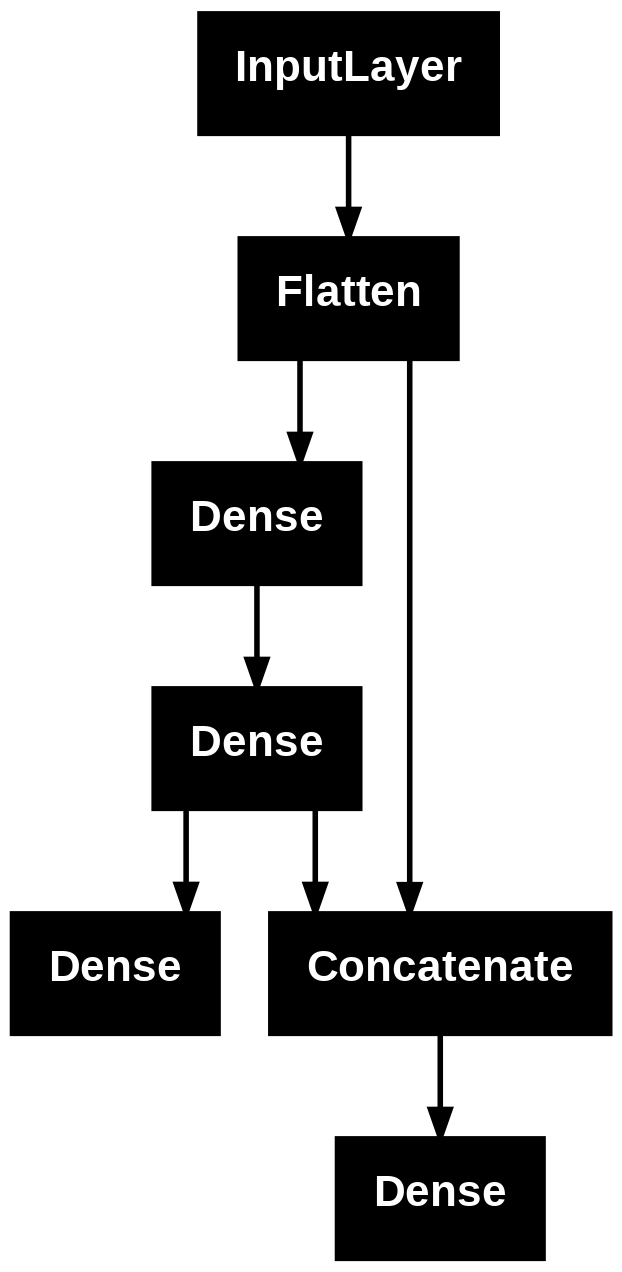

In [8]:
#arquitectura funcional 2
tf.keras.backend.clear_session()
input_l = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada')
flatten = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_l)

h1 = tf.keras.layers.Dense(200,activation='tanh',name='h1')(flatten)
h2 = tf.keras.layers.Dense(50,activation='tanh',name='h2')(h1)
#capa que concatena caracterísitacas extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2,flatten])
#se crean dos salidas:
output_A = tf.keras.layers.Dense(10,activation="softmax",name='outputA')(concat)#desde concatenación
output_B = tf.keras.layers.Dense(10,activation="softmax",name='outputB')(h2)#desde h2
#las entradas y salidas se ingresan como listas
model_fun = tf.keras.Model(inputs=input_l,outputs=[output_A, output_B])
#model_fun.summary()
tf.keras.utils.plot_model(model_fun)

**Nota**: si se cuenta con varias salidas se puede definir un mismo costo para cada salida, o una lista con los costos requeridos. Además, en la lista `loss_weights` se puede especificar el valor del peso asociado al costo de cada salida en el intervalo [0,1].

In [9]:
model_fun.compile(loss="sparse_categorical_crossentropy", #custom_loss(),#custom_loss(),#"sparse_categorical_crossentropy",
              optimizer="Adam",
              metrics=["accuracy","accuracy"]) #f1, precision, recall, crossentropy


- El entrenamiento se realiza de igual forma al utilizado con el modelo secuencial.

- Como se fijaron dos salidas, se debe ingresar una lista para los argumentos ytrain.

In [10]:
history = model_fun.fit(Xtrain, [ytrain,ytrain] , epochs=10,batch_size=64, # 32, 64, 128, 256
                    validation_split=0.3) # se fija el conjunto de validación como el 20% del de train

Epoch 1/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 1.4701 - outputA_accuracy: 0.7297 - outputA_loss: 0.7919 - outputB_accuracy: 0.7658 - outputB_loss: 0.6782 - val_loss: 0.9029 - val_outputA_accuracy: 0.8331 - val_outputA_loss: 0.4514 - val_outputB_accuracy: 0.8316 - val_outputB_loss: 0.4505
Epoch 2/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.8096 - outputA_accuracy: 0.8534 - outputA_loss: 0.4090 - outputB_accuracy: 0.8558 - outputB_loss: 0.4007 - val_loss: 0.7425 - val_outputA_accuracy: 0.8669 - val_outputA_loss: 0.3748 - val_outputB_accuracy: 0.8687 - val_outputB_loss: 0.3667
Epoch 3/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.7150 - outputA_accuracy: 0.8683 - outputA_loss: 0.3618 - outputB_accuracy: 0.8698 - outputB_loss: 0.3532 - val_loss: 0.7450 - val_outputA_accuracy: 0.8656 - val_outputA_loss: 0.3777 - val_outputB_accuracy: 0.8665 - val_outputB_loss: 0.3662
Epoch 4/10
657/657 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.6527 - outputA_accuracy: 0.8805

- Se presentan las curvas de desempeño:

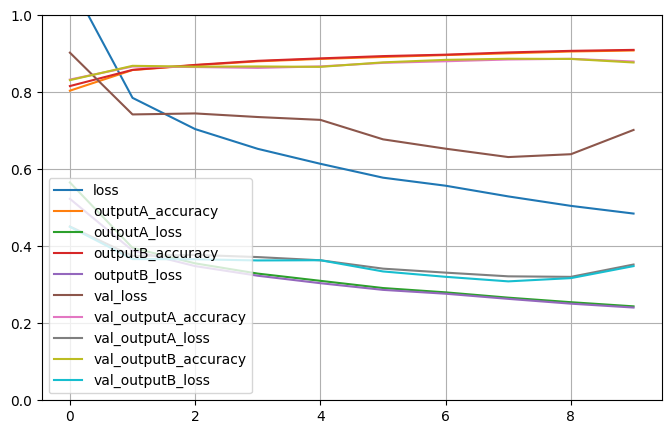

In [11]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

- Como el modelo generado presenta dos salidas, el rendimiento se discrimina por cada salida y el acumulado.

- A la hora de predecir la salida para una nueva muestra, se debe tener en cuenta la cantidad de salidas fijadas.

In [12]:
yestA,yestB = model_fun.predict(Xtest)
print(yestA.shape,yestB.shape)#salidas tipo 1 -K probabilidad de membresia a cada clase

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
(10000, 10) (10000, 10)


In [13]:
print(yestA[0].argmax(),ytest[0])#para estimar la etiqueta ordinal se encuentra el max por columnas

9 9


In [14]:
scoreA = model_fun.evaluate(Xtest,[ytest,ytest])#evaluacion
print(scoreA)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7741 - outputA_accuracy: 0.8694 - outputA_loss: 0.3850 - outputB_accuracy: 0.8646 - outputB_loss: 0.3891
[0.770008385181427, 0.3849734365940094, 0.38423293828964233, 0.8687999844551086, 0.8658000230789185]


# Grafiquemos los pesos respecto a las dimensiones de la imagen original

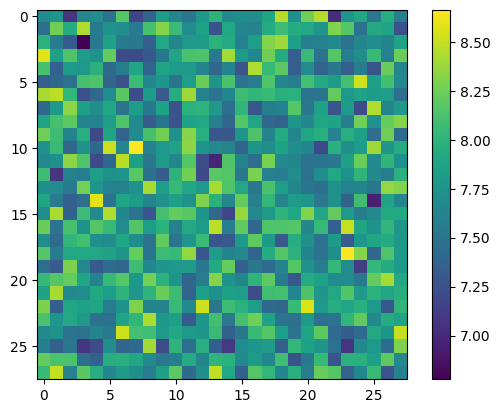

In [15]:
#se busca identificar las entradas más relevantes para la red
plt.imshow(abs(model.layers[1].get_weights()[0]).sum(axis=1).reshape(28,28))
plt.colorbar()
plt.show()

In [16]:
model.layers[1].get_weights()[1].shape # accediendo a los bias

(200,)

# Salidas parciales de la red

- La estrategia funcional nos permite acceder a partes intermedias de la red para encontrar mapas de características y verificar el aprendizaje de la representación.

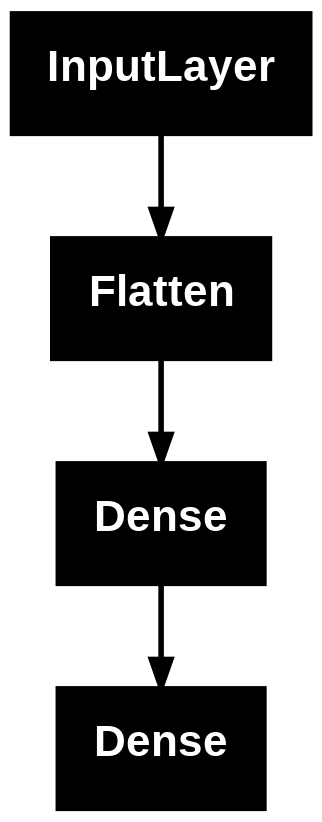

In [17]:
#crear nuevo modelo con salida parcial
model_B = tf.keras.Model(inputs=model_fun.inputs,outputs=model_fun.get_layer('h2').output) #se accede a capas por nombre
tf.keras.utils.plot_model(model_B) # modelo ya esta ajustado!


In [18]:
z = model_B.predict(Xtest) # salida en h2
z.shape

 41/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['entrada']
Received: inputs=Tensor(shape=(32, 28, 28))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['entrada']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)


(10000, 50)

### Dado que se fijaron 50 unidades, se pueden utilizar técnicas de reducción de dimensión para visualizar los patrones intermedios de la red en 2D.


# Principal Component Analysis (PCA)

Reducción de dimensión lineal basado en la preservación de la varianza

![PCA1](https://www.soloentendidos.com/wp-content/uploads/2021/06/Principal-Component-Analysis-second-principal_thumb-1.gif)


![PCA2](https://1.bp.blogspot.com/-pgMAHiIWvuw/Tql5HIXNdRI/AAAAAAAABLI/I2zPF5cLRwQ/s1600/clust.gif)


# t-student distributed Stochastic Neighbor Embedding (t-SNE)

Reducción de dimensión basado en la preservación de localidades (vecinos) utilizando medidas de información desde estimación no paramétrica de probabilidad en el espación de alta y baja dimensión, respectivamente.

![tsne](https://learnopencv.com/wp-content/uploads/2022/11/tsne.gif)

![tsne2](https://3.bp.blogspot.com/-NE01azL_JxU/Wxli17oYNzI/AAAAAAAACxQ/axOI2yy-Ft0QbqaekOyemm5Xn0wAFvRUwCLcBGAs/s640/image2.gif)

In [19]:
from sklearn.decomposition import PCA
zpca = PCA(n_components=2).fit_transform(z)
zpca.shape

(10000, 2)

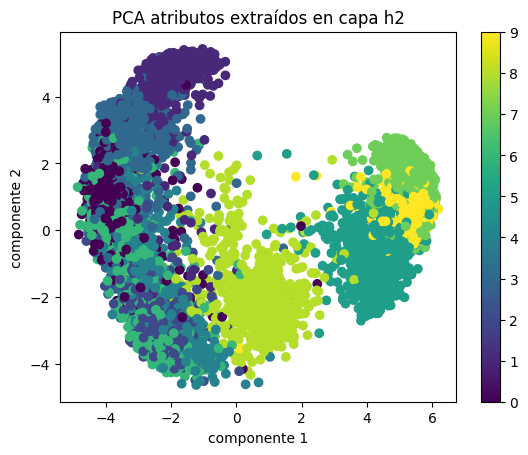

In [20]:
plt.scatter(zpca[:,0],zpca[:,1],c=ytest)
plt.colorbar()
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')
plt.show()

In [21]:
#plot mnist 2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z,y,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(16,10))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

- También, podemos revisar la distribución de las imágenes en el espacio proyectado:

Text(0.5, 1.0, 'PCA atributos extraídos en capa h2')

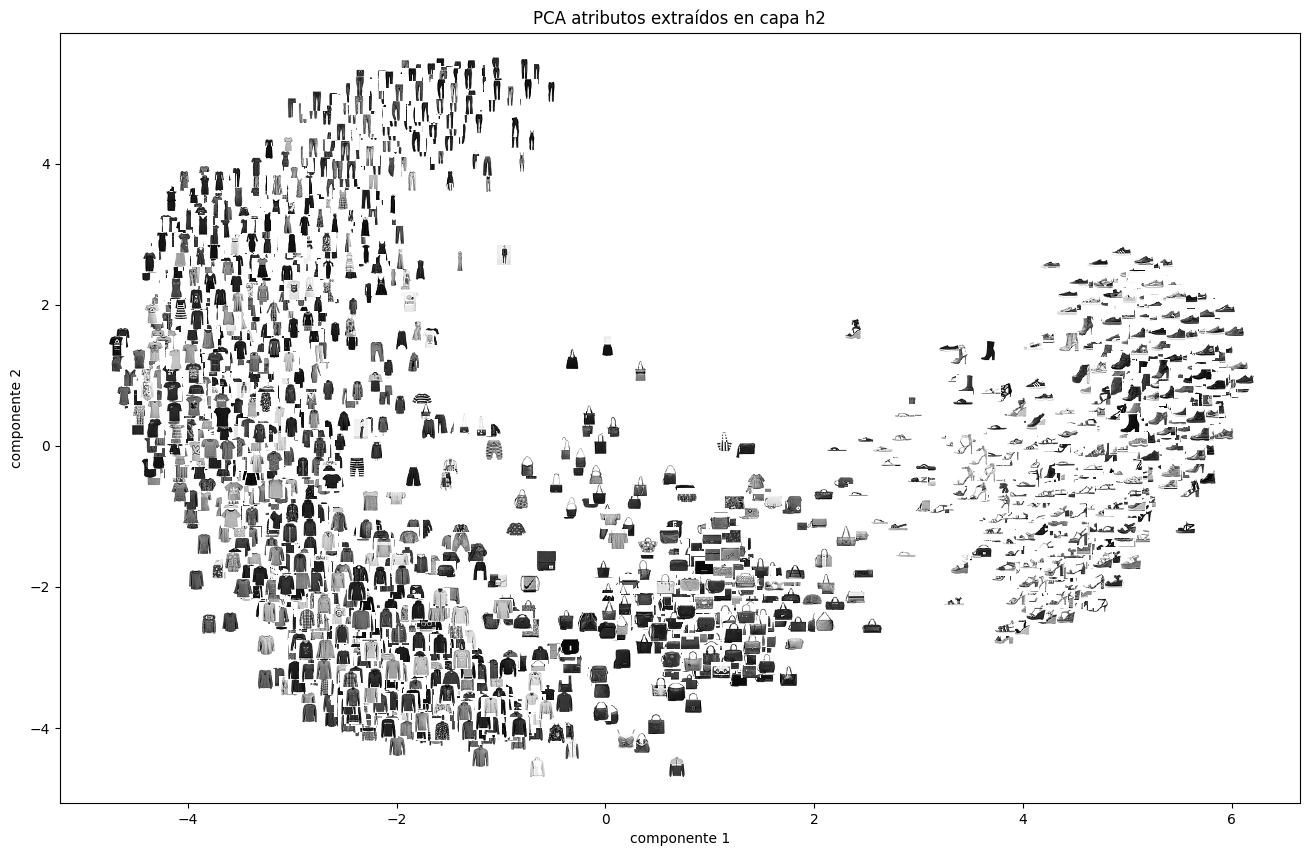

In [22]:
Ni =4000 # graficar Ni muestras como imagenes en espacio 2D
ind = np.random.randint(0,ytest.shape[0],Ni)
plot_mnist_2d(zpca[ind],ytest[ind],Xtest[ind],img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa h2')

# Ejercicio:

- Grafique el espacio proyectado de PCA en 2D (etiquetas e imágenes) para los atributos aprendidos por la capa de concatenación.

- Repita el proceso aplicando la técnica de reducción de dimensión [UMAP de RAPIDS](https://developer.nvidia.com/blog/even-faster-and-more-scalable-umap-on-the-gpu-with-rapids-cuml/).

- Plantee una nueva arquitectura tipo funcional utilizando capas convolucionales (Ver cuaderno [CNNs](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/3_Introduccion_CNN.ipynb)) para el entrenamiento de la base de datos Mnist-digitos, utilizando tres entradas: i) imágenes limpias, ii) y iii) imágenes con ruido blanco Gaussiano ante diferentes varianzas, y dos salidas i) estimación del digito, ii) estimación número par número impar.

In [23]:
#Ayuda de código:
#cargar fashion mnist o mnist
#(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_valid = X_train[:-55000], X_train[-55000:]
y_train, y_valid = y_train[:-55000], y_train[-55000:]

X_train = X_train[..., np.newaxis]/255.
X_valid = X_valid[..., np.newaxis]/255.
X_test = X_test[..., np.newaxis]/255.
print(X_train.shape,X_valid.shape,X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
(5000, 28, 28, 1) (55000, 28, 28, 1) (10000, 28, 28, 1)


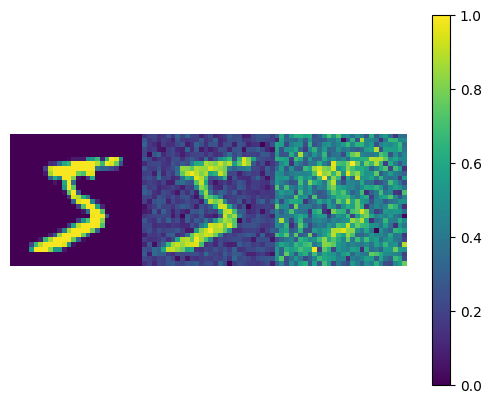

In [24]:
#crear entradas con y sin ruido
from sklearn.preprocessing import MinMaxScaler

var_ = [0.01,0.25]
inputs_train = [X_train]
inputs_valid = [X_valid]
inputs_test = [X_test]

#recorrer varianzas
for var_i in var_:
    dim = X_train.shape
    #definir ruido
    tmp = X_train + (np.sqrt(var_i)*np.random.randn(X_train.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T #fijar señal con ruido de 0 a 1
    inputs_train += [tmp.reshape(dim)]

    dim = X_valid.shape
    tmp = X_valid + (np.sqrt(var_i)*np.random.randn(X_valid.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_valid += [tmp.reshape(dim)]

    dim = X_test.shape
    tmp = X_test + (np.sqrt(var_i)*np.random.randn(X_test.shape[0],dim[1],dim[2],dim[3]))
    tmp = MinMaxScaler().fit_transform(tmp.reshape(dim[0],-1).T).T
    inputs_test += [tmp.reshape(dim)]


plt.imshow(np.c_[inputs_train[0][0,:,:,0],inputs_train[1][0,:,:,0],inputs_train[2][0,:,:,0]])
plt.axis('off')
plt.colorbar()
plt.show()

In [25]:
#veector de salida par o impar
ytrain_B = (ytrain % 2)
print(ytrain_B[10:])
print(ytrain[10:])

[0 1 1 ... 1 0 1]
[0 9 5 ... 3 0 5]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


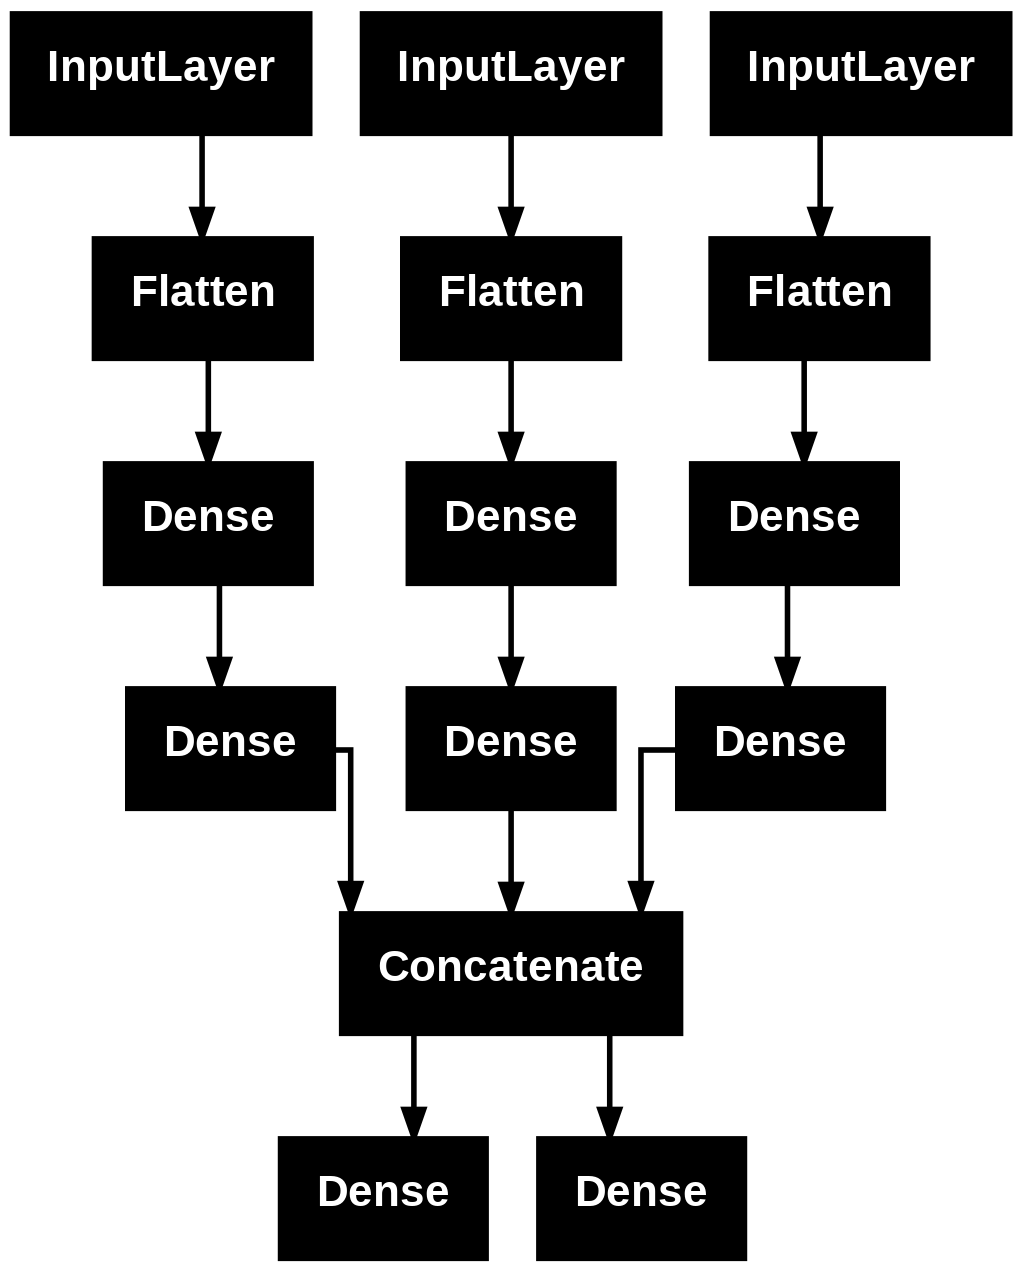

In [26]:
#arquitectura funcional 2 - Ayuda de código con capas densas - cambiar a capas cnn
tf.keras.backend.clear_session()
input_1 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada_1')
input_2 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada_2')
input_3 = tf.keras.layers.Input(shape=(Xtrain.shape[1],Xtrain.shape[2]), name='entrada_3')

flatten_1 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_1)
flatten_2 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_2)
flatten_3 = tf.keras.layers.Flatten(input_shape=(Xtrain.shape[1],Xtrain.shape[2]))(input_3)

h1_1 = tf.keras.layers.Dense(200,activation='tanh',name='h1_1')(flatten_1)
h2_1 = tf.keras.layers.Dense(50,activation='tanh',name='h2_1')(h1_1)

h1_2 = tf.keras.layers.Dense(200,activation='tanh',name='h1_2')(flatten_2)
h2_2 = tf.keras.layers.Dense(50,activation='tanh',name='h2_2')(h1_2)

h1_3 = tf.keras.layers.Dense(200,activation='tanh',name='h1_3')(flatten_3)
h2_3 = tf.keras.layers.Dense(50,activation='tanh',name='h2_3')(h1_3)

#capa que concatena caracterísitacas extraídas en h2 con imágenes de entrada
concat = tf.keras.layers.concatenate([h2_1,h2_2,h2_3])
#se crean dos salidas:
output_d = tf.keras.layers.Dense(10,activation="softmax",name='output_d')(concat)#desde concatenación
output_p = tf.keras.layers.Dense(1,activation="sigmoid",name='output_p')(concat)#desde h2
#las entradas y salidas se ingresan como listas
model_fun2 = tf.keras.Model(inputs=[input_1,input_2,input_3],outputs=[output_d, output_p])
#model_fun.summary()
tf.keras.utils.plot_model(model_fun2)

In [27]:
#Entrenar y ajustar el modelo, revisar rendimientos en cada salida

In [28]:
!pip install umap-learn -q


#Punto 1

A medida que el modelo avanza en su entrenamiento, mejora progresivamente su capacidad para representar los datos de forma significativa. En la capa Flatten, las imágenes ya han sido aplanadas, pero aún no presentan una estructura clara: las clases se encuentran mezcladas y no es fácil diferenciarlas. En la capa h1, comienzan a aparecer agrupamientos, lo que sugiere que la red empieza a identificar patrones relevantes. En h2, estos grupos se hacen más evidentes, reflejando una mejor organización entre distintos tipos de prendas. La capa OutputA muestra una separación más marcada entre clases, resultado de una representación más compleja y rica en información. Por su parte, OutputB también alcanza una buena organización, aunque su representación se basa más directamente en las características aprendidas por las capas ocultas, sin incorporar directamente la información de entrada original.

Acontinuacion se muestran las imagenes del proceso:


In [52]:
# Paso 1: Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paso 2: Librerías necesarias
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


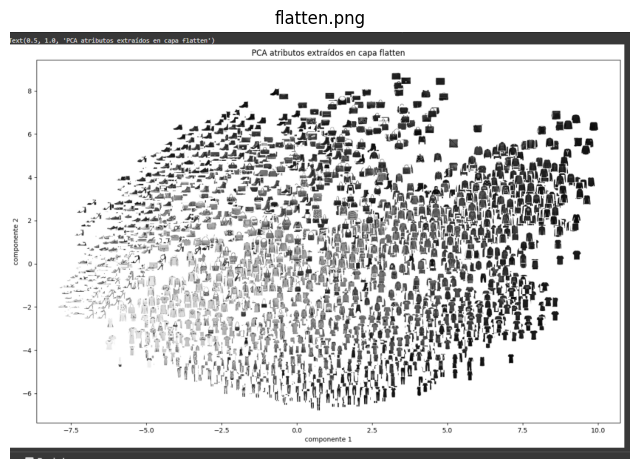

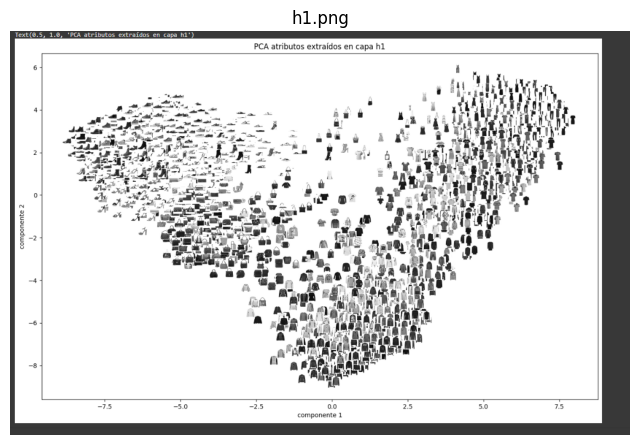

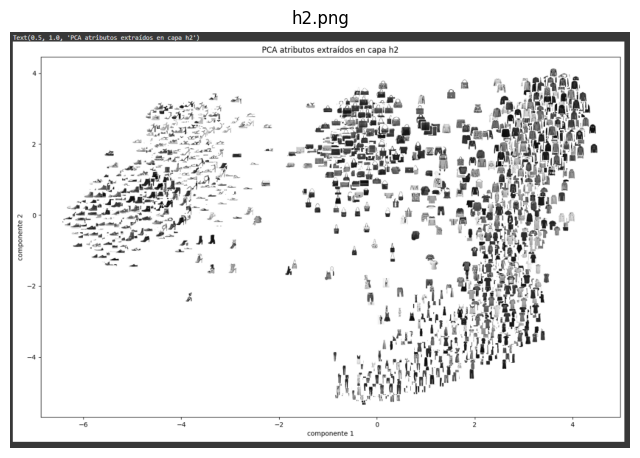

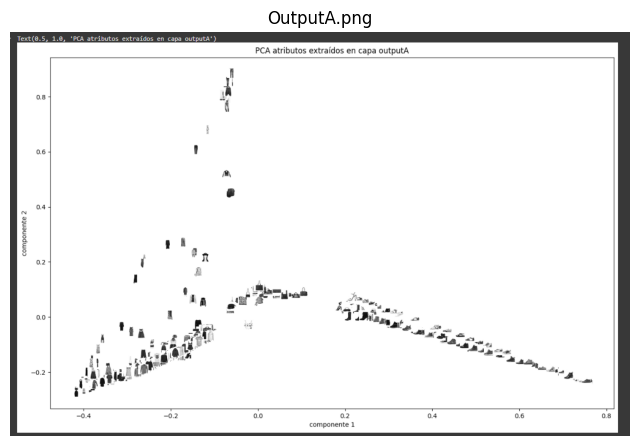

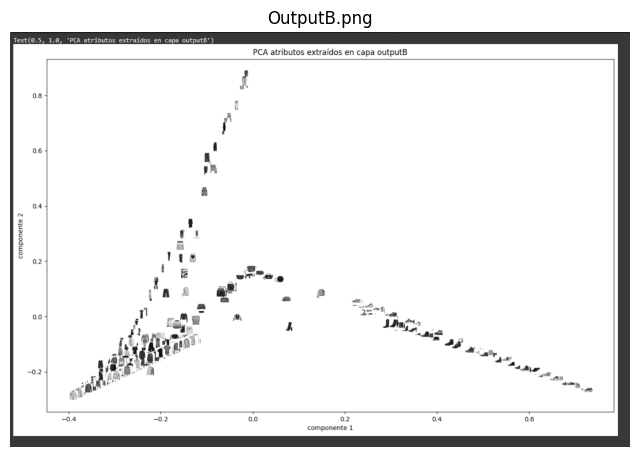

In [53]:
# Paso 3: Ruta de la carpeta de imágenes (ajústala si es necesario)
folder_path = '/content/drive/MyDrive/Procesamiento/'

# Paso 4: Obtener todos los archivos de imagen en esa carpeta
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Paso 5: Mostrar todas las imágenes
for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    img = mpimg.imread(img_path)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(img_name)
    plt.axis('off')
    plt.show()

#Punto 2

##PCA


In [29]:
# Modelo parcial con salida en la capa de concatenación
model_concat = tf.keras.Model(inputs=model_fun2.inputs,
                              outputs=model_fun2.get_layer('concatenate').output)

# Obtener la salida de la capa
Z_concat = model_concat.predict([X_test, X_test, X_test])
print(Z_concat.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
(10000, 150)


In [30]:
from sklearn.decomposition import PCA

Z_concat_pca = PCA(n_components=2).fit_transform(Z_concat)
print(Z_concat_pca.shape)


(10000, 2)


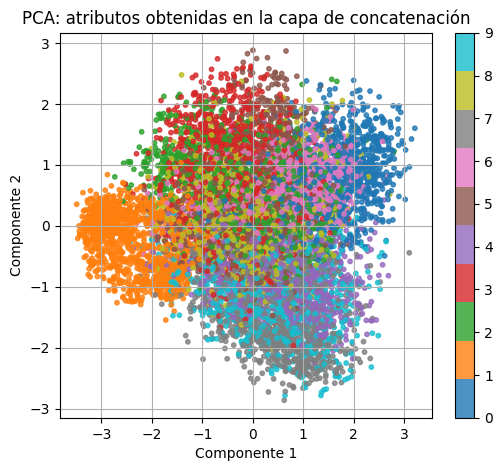

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(Z_concat_pca[:,0], Z_concat_pca[:,1], c=y_test, cmap='tab10', s=10, alpha=0.8)
plt.colorbar()
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.title("PCA: atributos obtenidas en la capa de concatenación")
plt.grid(True)
plt.show()


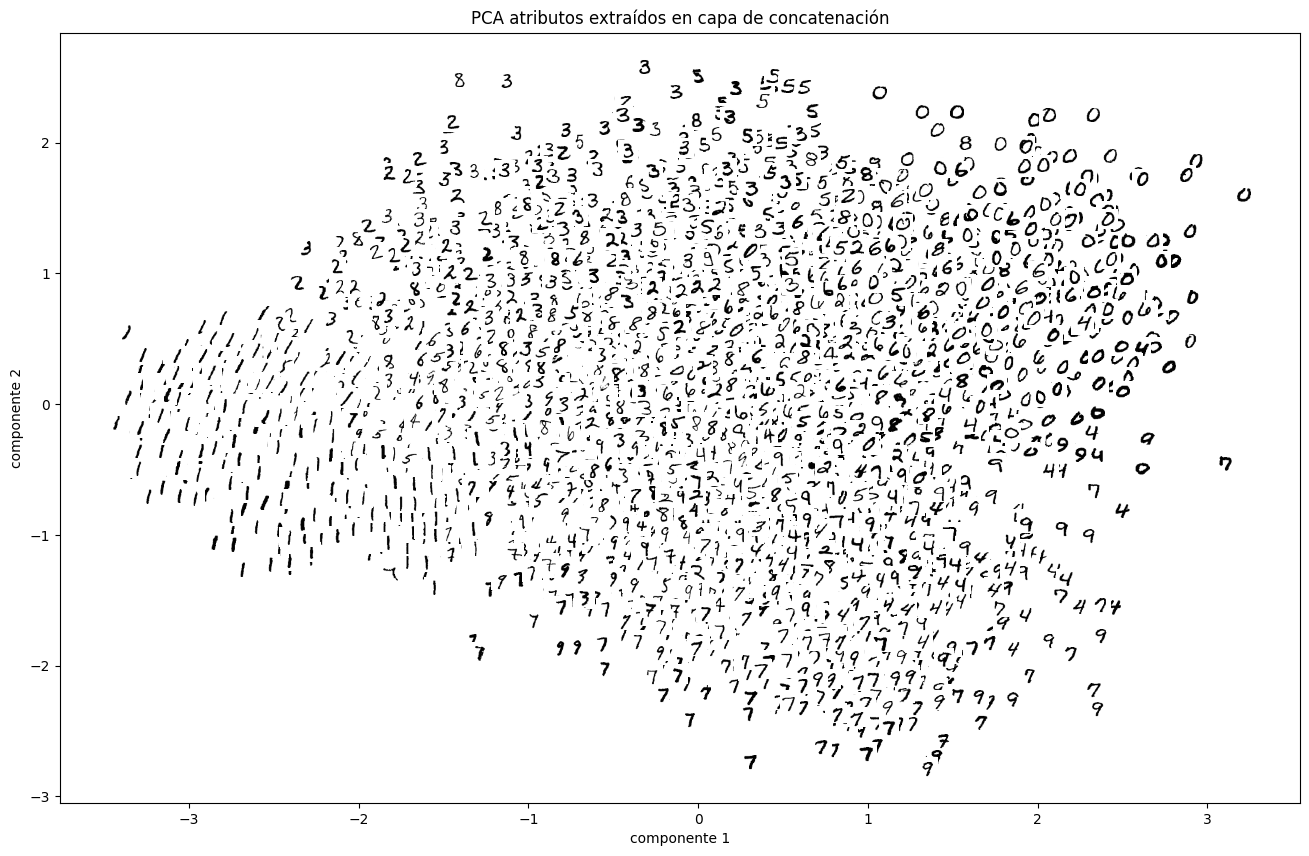

In [32]:

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def plot_mnist_2d(Z, y, images, img_w=28, img_h=28, zoom=0.5, cmap='binary'):
    fig, ax = plt.subplots(figsize=(16, 10))
    for i in range(Z.shape[0]):
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom, cmap=cmap)
        ab = AnnotationBbox(im, (Z[i, 0], Z[i, 1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i, 0], Z[i, 1])])
        ax.autoscale()

Ni = 3000
ind = np.random.randint(0, X_test.shape[0], Ni)
plot_mnist_2d(Z_concat_pca[ind], y_test[ind], X_test[ind], zoom=0.5)
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.title('PCA atributos extraídos en capa de concatenación')
plt.show()

##UMAP

In [33]:
import umap
from sklearn.preprocessing import StandardScaler

Z_concat_scaled = StandardScaler().fit_transform(Z_concat)

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
Z_concat_umap = umap_model.fit_transform(Z_concat_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


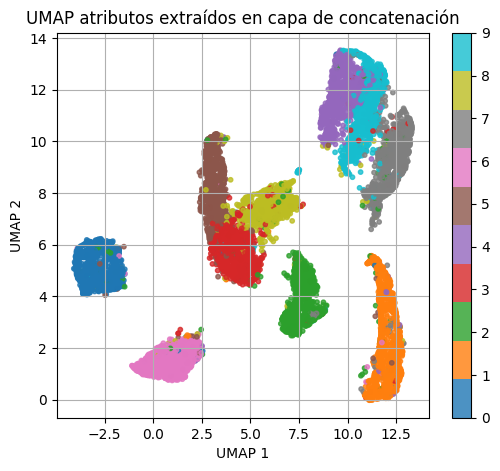

In [34]:
plt.figure(figsize=(6,5))
plt.scatter(Z_concat_umap[:,0], Z_concat_umap[:,1], c=y_test, cmap='tab10', s=10, alpha=0.8)
plt.colorbar()
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP: atributos extraídos en capa de concatenación")
plt.grid(True)
plt.show()


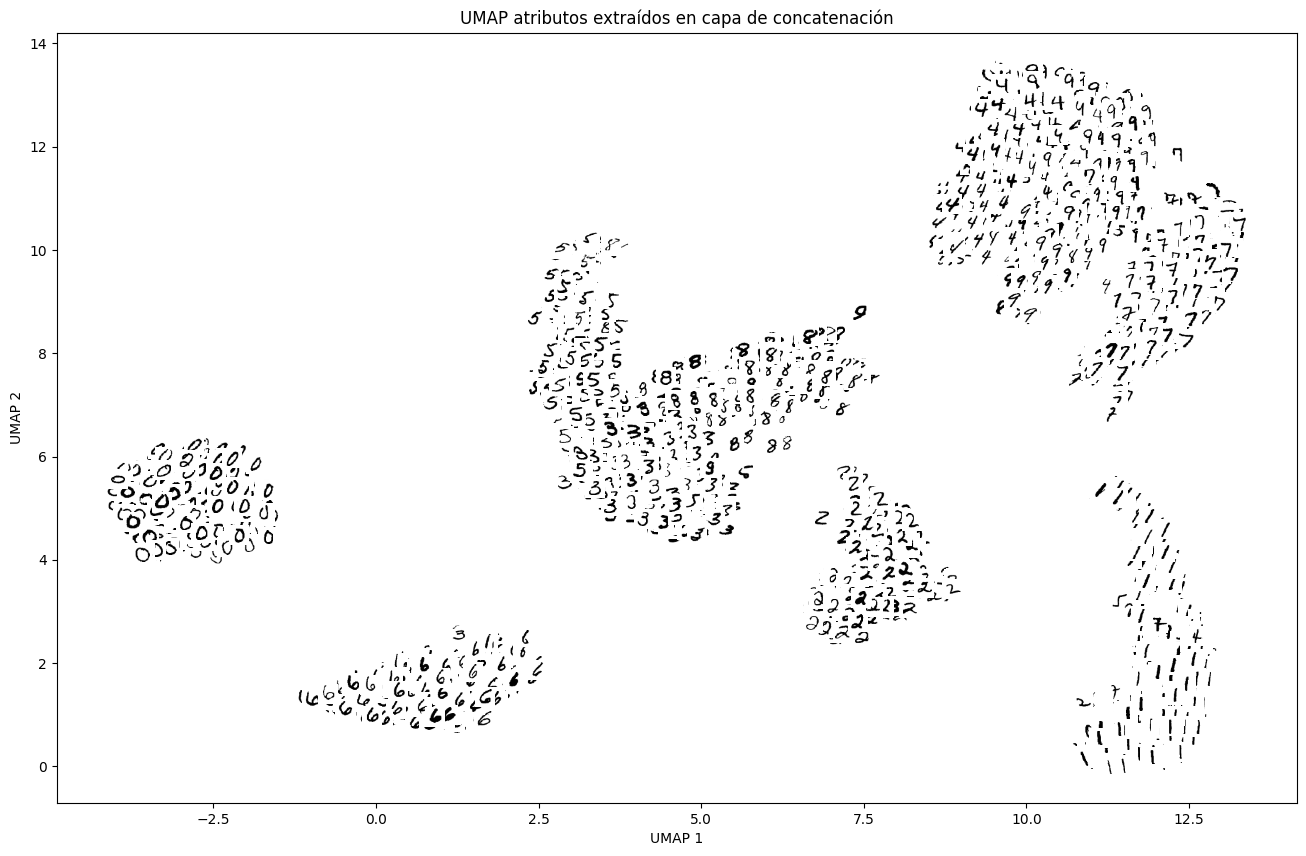

In [35]:
Ni = 3000
ind = np.random.randint(0, X_test.shape[0], Ni)
plot_mnist_2d(Z_concat_umap[ind], y_test[ind], X_test[ind], zoom=0.5)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP: atributos extraídos en capa de concatenación")
plt.show()



**CONCLUSIÓN:**

La proyección 2D con PCA muestra que la capa de concatenación captura cierta separación entre clases, aunque con solapamientos por su naturaleza lineal. En cambio, UMAP logra una agrupación más clara y definida, revelando mejor la estructura no lineal de los datos. Esto indica que los atributos aprendidos *contienen* información discriminativa que UMAP representa de forma más expresiva.

##CNN

In [36]:
tf.keras.backend.clear_session()

# Entradas
input_1 = tf.keras.layers.Input(shape=(28, 28, 1), name='entrada_limpia')
input_2 = tf.keras.layers.Input(shape=(28, 28, 1), name='entrada_ruido_1')
input_3 = tf.keras.layers.Input(shape=(28, 28, 1), name='entrada_ruido_2')

# Bloque CNN para cada entrada
def cnn_branch(x, name):
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', name=f'conv1_{name}')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name=f'pool1_{name}')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', name=f'conv2_{name}')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name=f'pool2_{name}')(x)
    x = tf.keras.layers.Flatten(name=f'flat_{name}')(x)
    return x

# Procesamiento de cada entrada
branch_1 = cnn_branch(input_1, "b1")
branch_2 = cnn_branch(input_2, "b2")
branch_3 = cnn_branch(input_3, "b3")

# Concatenación de los tres vectores
concat = tf.keras.layers.concatenate([branch_1, branch_2, branch_3], name='concatenate')

# Capa densa común
fc = tf.keras.layers.Dense(128, activation='relu', name='fc_concat')(concat)
drop = tf.keras.layers.Dropout(0.3)(fc)

# Salida 1: dígito (10 clases)
output_d = tf.keras.layers.Dense(10, activation='softmax', name='output_d')(drop)

# Salida 2: par/impar (1 salida binaria)
output_p = tf.keras.layers.Dense(1, activation='sigmoid', name='output_p')(drop)

# Modelo final
model_cnn = tf.keras.Model(inputs=[input_1, input_2, input_3],
                           outputs=[output_d, output_p])

tf.keras.utils.plot_model(model_cnn, show_shapes=True)
model_cnn.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ entrada_limpia      │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_ruido_1     │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ entrada_ruido_2     │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_b1 (Conv2D)   │ (None, 28, 28,    │        320 │ entrada_limpia[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_b2 (Conv2D)   │ (None, 28, 28,    │        320 │ entrada_ruido_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_b3 (Conv2D)   │ (None, 28, 28,    │        320 │ entrada_ruido_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_b1            │ (None, 14, 14,    │          0 │ conv1_b1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_b2            │ (None, 14, 14,    │          0 │ conv1_b2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_b3            │ (None, 14, 14,    │          0 │ conv1_b3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_b1 (Conv2D)   │ (None, 14, 14,    │     18,496 │ pool1_b1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_b2 (Conv2D)   │ (None, 14, 14,    │     18,496 │ pool1_b2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_b3 (Conv2D)   │ (None, 14, 14,    │     18,496 │ pool1_b3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2_b1            │ (None, 7, 7, 64)  │          0 │ conv2_b1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2_b2            │ (None, 7, 7, 64)  │          0 │ conv2_b2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2_b3            │ (None, 7, 7, 64)  │          0 │ conv2_b3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flat_b1 (Flatten)   │ (None, 3136)      │          0 │ pool2_b1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flat_b2 (Flatten)   │ (None, 3136)      │          0 │ pool2_b2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,262,219 (4.81 MB)

 Trainable params: 1,262,219 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model_cnn.compile(
    loss={'output_d': 'sparse_categorical_crossentropy',
          'output_p': 'binary_crossentropy'},
    optimizer='adam',
    metrics={'output_d': 'accuracy', 'output_p': 'accuracy'}
)

# Entrenamiento
history = model_cnn.fit(
    [inputs_train[0], inputs_train[1], inputs_train[2]],
    [y_train, y_train % 2],
    validation_data=([inputs_valid[0], inputs_valid[1], inputs_valid[2]], [y_valid, y_valid % 2]),
    epochs=10,
    batch_size=64
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 125ms/step - loss: 1.9192 - output_d_accuracy: 0.5321 - output_d_loss: 1.4200 - output_p_accuracy: 0.7325 - output_p_loss: 0.4989 - val_loss: 0.4898 - val_output_d_accuracy: 0.9080 - val_output_d_loss: 0.2995 - val_output_p_accuracy: 0.9263 - val_output_p_loss: 0.1901
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.4382 - output_d_accuracy: 0.9133 - output_d_loss: 0.2847 - output_p_accuracy: 0.9409 - output_p_loss: 0.1536 - val_loss: 0.2793 - val_output_d_accuracy: 0.9425 - val_output_d_loss: 0.1814 - val_output_p_accuracy: 0.9651 - val_output_p_loss: 0.0978
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.3332 - output_d_accuracy: 0.9346 - output_d_loss: 0.2079 - output_p_accuracy: 0.9545 - output_p_loss: 0.1253 - val_loss: 0.2188 - val_output_d_accuracy: 0.9541 - val_output_d_loss: 0.1477 - val_output_p_accuracy: 0.9740 - val_output_p_loss: 0.0710
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.2041 - out

In [38]:
model_cnn.compile(
    loss={'output_d': 'sparse_categorical_crossentropy',
          'output_p': 'binary_crossentropy'},
    optimizer='adam',
    metrics={'output_d': 'accuracy', 'output_p': 'accuracy'}
)

# Entrenamiento (X_train1, X_train2, X_train3 deben estar normalizados)
history = model_cnn.fit(
    [inputs_train[0], inputs_train[1], inputs_train[2]],
    [y_train, y_train % 2],
    validation_data=([inputs_valid[0], inputs_valid[1], inputs_valid[2]], [y_valid, y_valid % 2]),
    epochs=10,
    batch_size=64
)


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.0635 - output_d_accuracy: 0.9839 - output_d_loss: 0.0454 - output_p_accuracy: 0.9940 - output_p_loss: 0.0181 - val_loss: 0.1547 - val_output_d_accuracy: 0.9702 - val_output_d_loss: 0.1034 - val_output_p_accuracy: 0.9833 - val_output_p_loss: 0.0512
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.0578 - output_d_accuracy: 0.9854 - output_d_loss: 0.0383 - output_p_accuracy: 0.9933 - output_p_loss: 0.0195 - val_loss: 0.1520 - val_output_d_accuracy: 0.9709 - val_output_d_loss: 0.1039 - val_output_p_accuracy: 0.9843 - val_output_p_loss: 0.0480
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0420 - output_d_accuracy: 0.9905 - output_d_loss: 0.0281 - output_p_accuracy: 0.9954 - output_p_loss: 0.0139 - val_loss: 0.1645 - val_output_d_accuracy: 0.9714 - val_output_d_loss: 0.1037 - val_output_p_accuracy: 0.9809 - val_output_p_loss: 0.0607
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0490 - ou

In [39]:
model_concat_cnn = tf.keras.Model(inputs=model_cnn.inputs,
                                  outputs=model_cnn.get_layer('concatenate').output)


Z_cnn = model_concat_cnn.predict([inputs_test[0], inputs_test[1], inputs_test[2]])
print("Shape salida 'concatenate':", Z_cnn.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Shape salida 'concatenate': (10000, 9408)


In [40]:
from sklearn.decomposition import PCA

Z_cnn_pca = PCA(n_components=2).fit_transform(Z_cnn)
print("Shape PCA:", Z_cnn_pca.shape)


Shape PCA: (10000, 2)


In [41]:
import umap
from sklearn.preprocessing import StandardScaler

Z_cnn_scaled = StandardScaler().fit_transform(Z_cnn)

umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
Z_cnn_umap = umap_model.fit_transform(Z_cnn_scaled)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


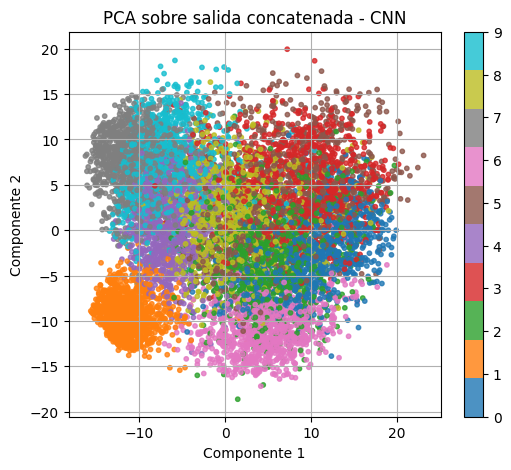

In [42]:
plt.figure(figsize=(6,5))
plt.scatter(Z_cnn_pca[:,0], Z_cnn_pca[:,1], c=y_test, cmap='tab10', s=10, alpha=0.8)
plt.colorbar()
plt.title("PCA sobre salida concatenada - CNN")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.grid(True)
plt.show()




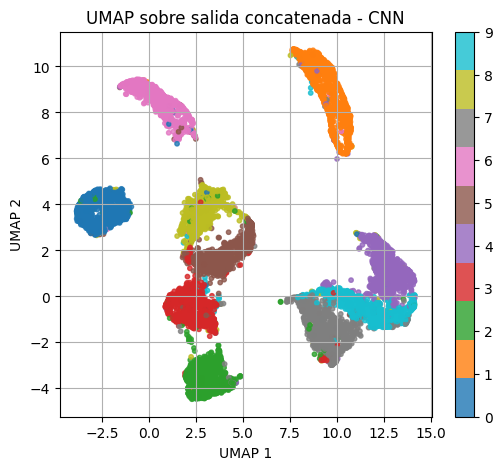

In [43]:
plt.figure(figsize=(6,5))
plt.scatter(Z_cnn_umap[:,0], Z_cnn_umap[:,1], c=y_test, cmap='tab10', s=10, alpha=0.8)
plt.colorbar()
plt.title("UMAP sobre salida concatenada - CNN")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

In [44]:
# Evaluar en conjunto de prueba
eval_result = model_cnn.evaluate(
    [inputs_test[0], inputs_test[1], inputs_test[2]],
    [y_test, y_test % 2],
    verbose=1
)

print("\nMétricas en test:")
print(f"Pérdida total:        {eval_result[0]:.4f}")
print(f"Pérdida dígito (0–9): {eval_result[1]:.4f}")
print(f"Accuracy dígito:      {eval_result[3]:.4f}")
print(f"Pérdida par/impar:    {eval_result[2]:.4f}")
print(f"Accuracy par/impar:   {eval_result[4]:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1420 - output_d_accuracy: 0.9740 - output_d_loss: 0.0949 - output_p_accuracy: 0.9863 - output_p_loss: 0.0471

Métricas en test:
Pérdida total:        0.1357
Pérdida dígito (0–9): 0.0877
Accuracy dígito:      0.9776
Pérdida par/impar:    0.0479
Accuracy par/impar:   0.9866
